## Housing Prices Prediction - Kaggle

In this notebook, the following steps are to be performed:

- Exploratory Data Analysis
- Data imputation
- Feature Engineering
- base line models
- L1 regularization for features selection
- Train on new set of features
- Learning ensemble using Stacking classifier
- Model selection
- generate predictions for test data

In [1]:
import pandas as pd
import numpy as np 


import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew

from subprocess import check_output


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [6]:
print("Train data shape before droping Id: {}".format(train.shape))
print("Test data shape before droping Id: {}".format(test.shape))

traind_id = train['Id']
test_id   = test['Id']

train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

print("\nTrain data shape after droping Id: {}".format(train.shape))
print("Test data shape after droping Id: {}".format(test.shape))

Train data shape before droping Id: (1460, 81)
Test data shape before droping Id: (1459, 80)

Train data shape after droping Id: (1460, 80)
Test data shape after droping Id: (1459, 79)


## Data Processing

### Outliers

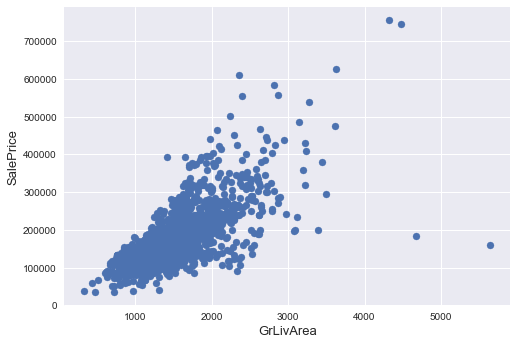

In [7]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

We can see at the bottom right two with extremely large GrLivArea that are of a low price. These values are huge oultliers. Therefore, we can safely delete them.

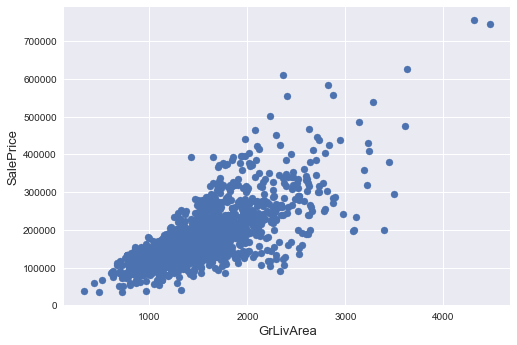

In [8]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

## Target Variable

**SalePrice** is the variable to predict

In [9]:
train['SalePrice'].describe()

count      1458.000000
mean     180932.919067
std       79495.055285
min       34900.000000
25%      129925.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

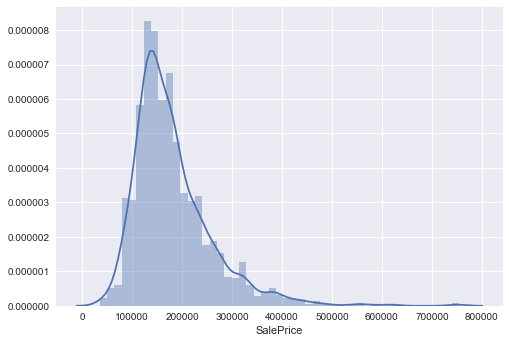

In [10]:
# Target variable
sns.distplot(train['SalePrice'])

In [11]:
print('Skewness: %f'% train['SalePrice'].skew())
print('Kurtosis: %f'% train['SalePrice'].kurt())

Skewness: 1.881296
Kurtosis: 6.523067


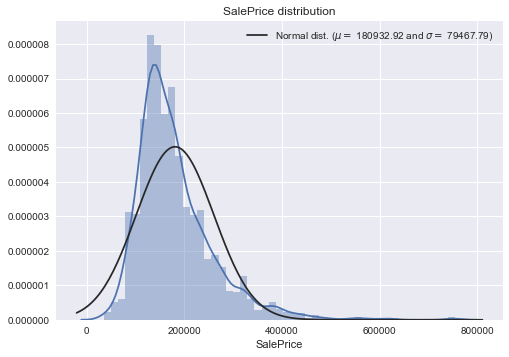

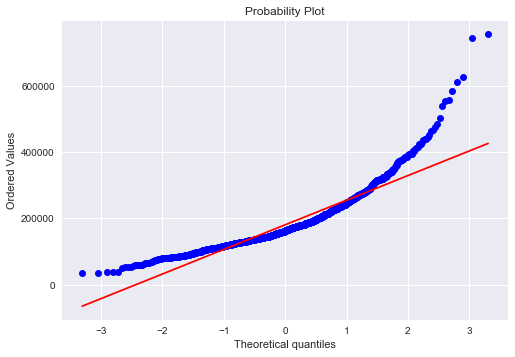

In [12]:
sns.distplot(train['SalePrice'], fit=norm)

(mu, sigma) = norm.fit(train['SalePrice'])

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='best')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


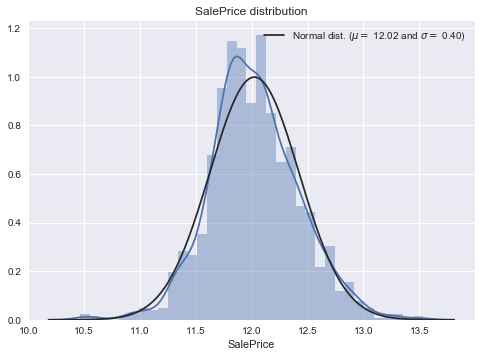

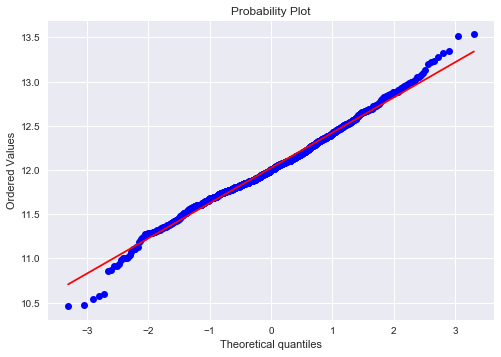

In [13]:
train['SalePrice'] = np.log1p(train['SalePrice'])

sns.distplot(train['SalePrice'], fit=norm)

(mu, sigma) = norm.fit(train['SalePrice'])

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='best')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


## Features Engineering

In [14]:
ntrain = train.shape[0]
ntest  = test.shape[0]

y_train = train.SalePrice.values

all_data = pd.concat((train,test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


### Missing Data

In [15]:
all_data_total = (all_data.isnull().sum())
all_data_percent = (all_data.isnull().sum()/len(all_data))*100
all_data_total = all_data_total.drop(all_data_total[all_data_total==0].index).sort_values(ascending=False)[:30]
all_data_percent = all_data_percent.drop(all_data_percent[all_data_percent==0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Number of Missing data':all_data_total,'Missing Ratio':all_data_percent})
missing_data.head(20)

,Missing Ratio,Number of Missing data
PoolQC,99.691464,2908
MiscFeature,96.400411,2812
Alley,93.212204,2719
Fence,80.425094,2346
FireplaceQu,48.680151,1420
LotFrontage,16.660953,486
GarageQual,5.450806,159
GarageCond,5.450806,159
GarageFinish,5.450806,159
GarageYrBlt,5.450806,159


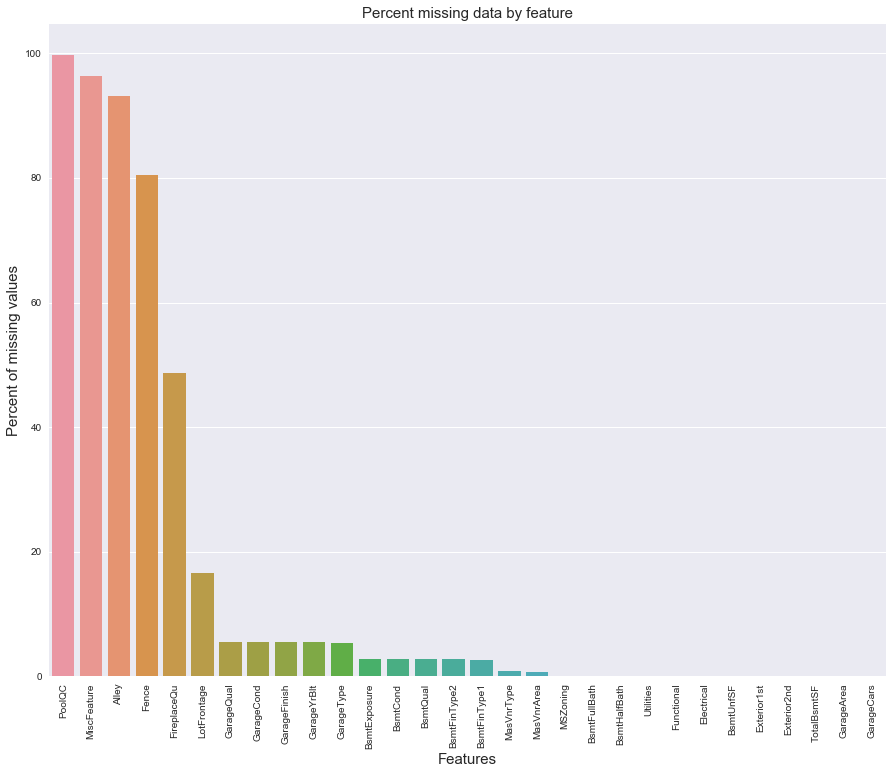

In [16]:
f, ax = plt.subplots(figsize=(15,12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_percent.index, y=all_data_percent)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [17]:
# delete features with missing values more or equal to 20%
# Note: LotFrontage keep it or delete it ?
len(all_data.columns)

79

In [18]:
# imputing data

In [19]:
missing_data.index

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage',
       'GarageQual', 'GarageCond', 'GarageFinish', 'GarageYrBlt', 'GarageType',
       'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1',
       'MasVnrType', 'MasVnrArea', 'MSZoning', 'BsmtFullBath', 'BsmtHalfBath',
       'Utilities', 'Functional', 'Electrical', 'BsmtUnfSF', 'Exterior1st',
       'Exterior2nd', 'TotalBsmtSF', 'GarageArea', 'GarageCars'],
      dtype='object')

In [20]:
cols_del = list(missing_data[missing_data['Missing Ratio']>17].index)
all_data.drop(cols_del, axis=1,inplace=True)

In [21]:
all_data.apply(lambda x: x.isnull().sum(), axis=1).value_counts()

0     2200
1      469
5      179
6       24
2       18
10      13
3        6
7        5
11       2
4        1
dtype: int64

#### LotFrontage

In [22]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

#### Looking at: GarageType, GarageFinish, GarageQual, GarageCond


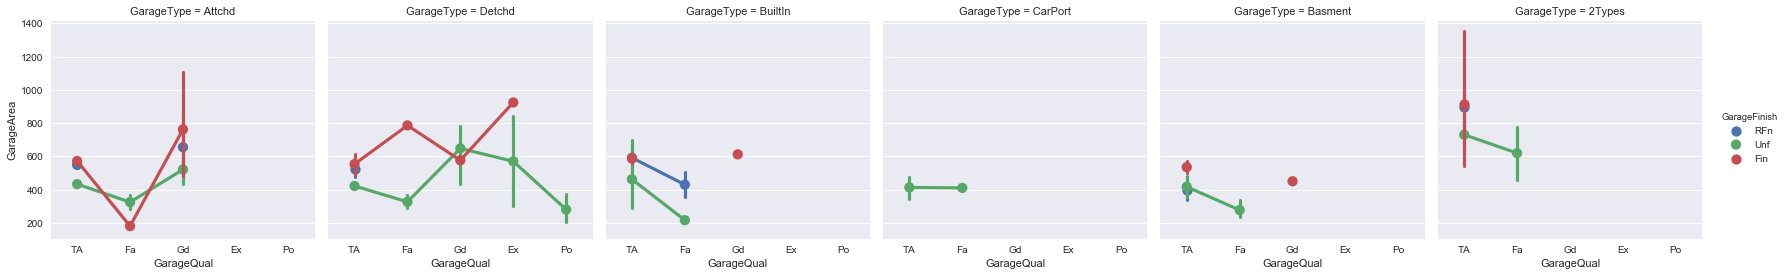

In [27]:
sns.factorplot(x='GarageQual',y='GarageArea',hue='GarageFinish',col='GarageType',data=all_data)
#Qual: Fa, finish: Unf, type: Basment , cond: TA

In [28]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    na_data=all_data[all_data[col].isnull()]
    print(na_data['GarageArea'].value_counts())

0.0    157
Name: GarageArea, dtype: int64
0.0      157
360.0      1
Name: GarageArea, dtype: int64
0.0      157
360.0      1
Name: GarageArea, dtype: int64
0.0      157
360.0      1
Name: GarageArea, dtype: int64


In [26]:
all_data[(all_data['GarageFinish'].isnull())&(all_data['GarageArea']>1)].index[0]

2124

there is one data point that has GarageArea equal to 360, which is in test set, there is no need to do anything about it


In [29]:
# just replace 'Na' values with the string 'None'
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

#### Next: GarageYrBlt, GarageArea, GarageCars

In [30]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    print(col,all_data[col].isnull().sum())
    print(all_data[all_data[col].isnull()]['GarageArea'].value_counts())

GarageYrBlt 159
0.0      157
360.0      1
Name: GarageArea, dtype: int64
GarageArea 1
Series([], Name: GarageArea, dtype: int64)
GarageCars 1
Series([], Name: GarageArea, dtype: int64)


In [37]:
all_data[all_data['GarageCars'].isnull()].index[0]

2574

In [51]:
# replace 'GarageYrBlt' missings values with zero
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

- BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : missing values are likely zero for having no basement 

In [39]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

- BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : For all these categorical basement-related features, NaN means that there is no basement.

In [40]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

- MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.

In [41]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'

In [42]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

- Utilities is a constant and should be deleted

In [43]:
print(all_data['Utilities'].value_counts())
all_data = all_data.drop(['Utilities'], axis=1)

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64


- data description quotes "Assume typical unless deductions are warranted", hence we replace NA with Typ

In [44]:
all_data['Functional'] = all_data['Functional'].fillna('Typ')

- Electrical : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.


In [45]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

- KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.

In [46]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

- Exterior1st and Exterior2nd : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string

In [47]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

- SaleType : Fill in again with most frequent which is "WD"

In [48]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [49]:
all_data['MSSubClass'].isnull().sum()

0

In [52]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


in Data description the cols: 'MSSubClass','OverallCond','YrSold','MoSold' are set to be categorical, thus, convert integers to strings

In [53]:
for col in ('MSSubClass','OverallCond','YrSold','MoSold'):
    print(all_data[col].unique(),all_data[col].dtypes)

[ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40 150] int64
[5 8 6 7 4 2 3 9 1] int64
[2008 2007 2006 2009 2010] int64
[ 2  5  9 12 10  8 11  4  1  7  3  6] int64


In [54]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [55]:
obj_col=all_data.select_dtypes(include=['O']).columns.tolist()

In [56]:
print(obj_col, len(obj_col))

['BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MoSold', 'Neighborhood', 'OverallCond', 'PavedDrive', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'YrSold'] 41


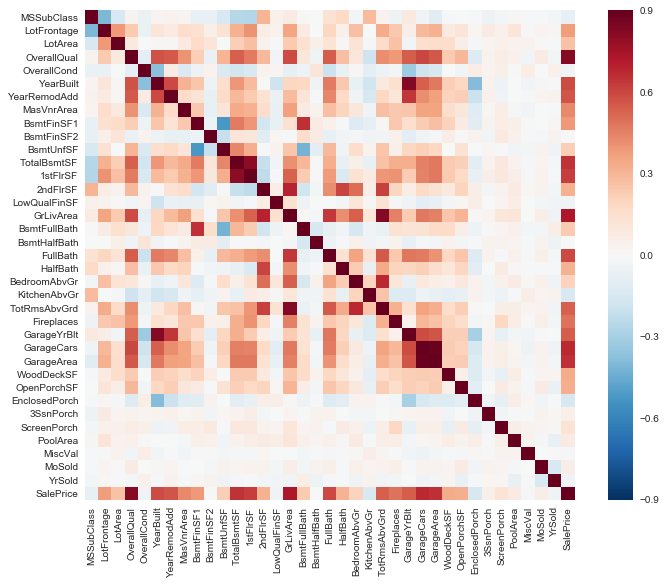

In [57]:
# Data Correlation
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

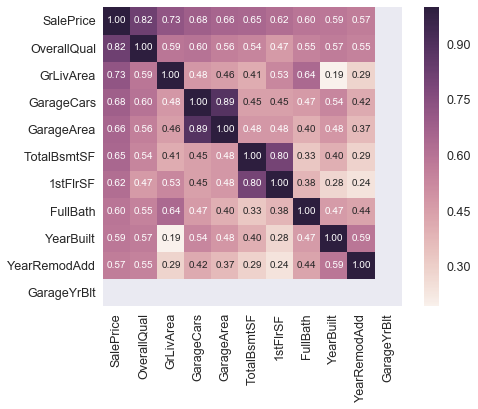

In [58]:
k=11
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f'
                , annot_kws={'size':10}, yticklabels=cols.values,
                xticklabels=cols.values)
plt.show()

In [59]:
corr_dic = {}
num_col = train.select_dtypes(exclude=['O'])
num_col.drop('SalePrice',axis=1, inplace=True)
for col in num_col:
    ser = abs(train.drop('SalePrice',axis=1).corr()[col]).sort_values(ascending=False)
    ser = ser[ser>0.5][1:]
    corr_dic[col] = {}
    for i,j in enumerate(ser.index.tolist()):
        if ser[i] > 0.5:
            corr_dic[col][j] = ser[i]
corr_dic

f:\Users\Tahar\Anacondanew\envs\ztdl\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


{'1stFlrSF': {'GrLivArea': 0.53369718228247909,
  'TotalBsmtSF': 0.80382962792561374},
 '2ndFlrSF': {'BedroomAbvGr': 0.50406818243187823,
  'GrLivArea': 0.69467814850935539,
  'HalfBath': 0.60883029507789654,
  'TotRmsAbvGrd': 0.61403389368073913},
 '3SsnPorch': {},
 'BedroomAbvGr': {'2ndFlrSF': 0.50406818243187823,
  'GrLivArea': 0.53810203311126259,
  'TotRmsAbvGrd': 0.68038969750836986},
 'BsmtFinSF1': {'BsmtFullBath': 0.65850685045473356,
  'BsmtUnfSF': 0.52230319287420257},
 'BsmtFinSF2': {},
 'BsmtFullBath': {'BsmtFinSF1': 0.65850685045473356},
 'BsmtHalfBath': {},
 'BsmtUnfSF': {'BsmtFinSF1': 0.52230319287420257},
 'EnclosedPorch': {},
 'Fireplaces': {},
 'FullBath': {'GrLivArea': 0.63837846374151141,
  'OverallQual': 0.54841970919691219,
  'TotRmsAbvGrd': 0.55303847086978009},
 'GarageArea': {'GarageCars': 0.88730449839192049,
  'GarageYrBlt': 0.56502273925117386,
  'OverallQual': 0.55723003756796863},
 'GarageCars': {'GarageArea': 0.88730449839192049,
  'GarageYrBlt': 0.588524

There is multicollinearity that could be inspected later to improve model performance


In [60]:
from sklearn.preprocessing import LabelEncoder
cols = ('BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 73)


In [61]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [62]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [63]:
# use BoxCox to transform skewed features
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 55 skewed numerical features to Box Cox transform


In [64]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 211)


In [65]:
train = all_data[:ntrain]
test = all_data[ntrain:]

## Modeling

In [169]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [106]:
#Validation function
n_folds = 5

def rmsle_cv(model, df):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df.values)
    rmse= np.sqrt(-cross_val_score(model, df.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [68]:
#Base model
models={}
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
models['lasso'] = lasso
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
models['ENet'] = ENet
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
models['KRR'] = KRR
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=6, max_features='sqrt', 
                                   loss='huber', random_state =5)
models['GBosst'] = GBoost
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.02, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1, nthread = -1)
models['model_xgb'] = model_xgb
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=6,
                              learning_rate=0.08, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11, reg_lambda=0.4)
models['model_lgb'] = model_lgb

In [222]:
for model_name,model in models.items():
    score = rmsle_cv(model, train)
    print("\n{} score: {:.4f} ({:.4f})\n".format(model_name,score.mean(), score.std()))


model_xgb score: 0.1153 (0.0065)


GBosst score: 0.1176 (0.0086)


model_lgb score: 0.1181 (0.0070)


KRR score: 0.1149 (0.0074)


ENet score: 0.1112 (0.0074)


lasso score: 0.1112 (0.0073)



In [223]:
# Use basic stacking model: Averaging the score of different models
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [225]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models,train)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1082 (0.0078)



In [226]:
#A helper method for pretty-printing linear models
def pretty_print_linear(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name)
                                   for coef, name in lst)

In [227]:
# Use Lasso for features selection
ls = Lasso(alpha =0.0005, random_state=1)
rs = RobustScaler()
xrs= rs.fit_transform(train)
ls.fit(xrs, y_train)

Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)

In [228]:
clist = list(zip(ls.coef_, list(train.columns)))

In [229]:
# Select features that have coef different from zero
sel_feat = []
for i in clist:
    if i[0] != 0:
        sel_feat.append(i[1])

In [230]:
# use the new subset of features
train_sel_feat = train[sel_feat]
test_sel_feat = test[sel_feat]

In [231]:
# train base models again
for model_name,model in models.items():
    score = rmsle_cv(model, train_sel_feat)
    print("\n{} score: {:.4f} ({:.4f})\n".format(model_name,score.mean(), score.std()))


model_xgb score: 0.1145 (0.0058)


GBosst score: 0.1207 (0.0079)


model_lgb score: 0.1168 (0.0068)


KRR score: 0.1134 (0.0043)


ENet score: 0.1102 (0.0070)


lasso score: 0.1104 (0.0070)



In [232]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models, train_sel_feat)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1073 (0.0066)



In [233]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [234]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = make_pipeline(RobustScaler(), lasso))

score = rmsle_cv(stacked_averaged_models, train_sel_feat)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1064 (0.0067)


In [235]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [236]:
# Train and predict stacked model
stacked_averaged_models.fit(train_sel_feat.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train_sel_feat.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test_sel_feat.values))
print(rmsle(y_train, stacked_train_pred))

0.0714989129073


In [237]:
# Train and predict for xgb
model_xgb.fit(train_sel_feat, y_train)
xgb_train_pred = model_xgb.predict(train_sel_feat)
xgb_pred = np.expm1(model_xgb.predict(test_sel_feat))
print(rmsle(y_train, xgb_train_pred))

0.0839969139077


In [238]:
# Train and predict for lgb
model_lgb.fit(train_sel_feat, y_train)
lgb_train_pred = model_lgb.predict(train_sel_feat)
lgb_pred = np.expm1(model_lgb.predict(test_sel_feat.values))
print(rmsle(y_train, lgb_train_pred))

0.0543405796397


In [260]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.5+
               xgb_train_pred*0.25 + lgb_train_pred*0.25 ))

RMSLE score on train data:
0.0672255529726


In [261]:
ensemble = stacked_pred*0.5 + xgb_pred*0.25 + lgb_pred*0.25

In [262]:
# Create submission
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)